## Installation of TensorFlow IO and Pydub

In [1]:
!pip install -q tensorflow_io
!pip install -q pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 62.5 MB/s eta 0:00:00


## Library and Module Imports

The following libraries and modules are imported:

- `os`: for operating system related functionality
- `shutil`: for file and directory operations
- `random`: for generating random numbers
- `librosa`: for audio processing
- `librosa.display`: for audio visualization
- `numpy as np`: for numerical computations
- `matplotlib.pyplot as plt`: for plotting graphs and charts
- `soundfile as sf`: for reading and writing audio files
- `pandas as pd`: for data manipulation and analysis
- `tensorflow as tf`: for deep learning framework
- `tensorflow_io as tfio`: for TensorFlow I/O operations
- `tensorflow_hub as hub`: for using pre-trained models from TensorFlow Hub
- `KFold` from `sklearn.model_selection`: for K-fold cross-validation
- `wavfile` from `scipy.io`: for reading WAV audio files
- `AudioSegment` from `pydub`: for audio segmentation
- `WhiteNoise` from `pydub.generators`: for generating white noise
- `speedup` from `pydub.effects`: for audio speed manipulation

In [2]:
import os
import shutil
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import KFold
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.generators import WhiteNoise
from pydub.effects import speedup

## Download Dataset

In [3]:
!gdown 1koPDoUV0mSWXLva9gJtgCavo-agtyoqo

Downloading...
From: https://drive.google.com/uc?id=1koPDoUV0mSWXLva9gJtgCavo-agtyoqo
To: /content/voice_classification-dataset-65.zip
100% 146M/146M [00:04<00:00, 31.9MB/s]


## Unzipping the Dataset

In [9]:
!unzip -q /content/voice_classification-dataset-65.zip -d /content/calis_voice_dataset

## Dataset Path and YAMNet Model

In [10]:
DATASET = "/content/calis_voice_dataset"
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

## Loading and Resampling WAV File

In [11]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    # wav = wav / tf.int16.max
    return wav

## WavVisualizer Class

In [12]:
class WavVisualizer:
    def __init__(self, source_path):
        self.source_path = source_path

    def visualize_random_wav(self):
        # Get class folders in the source path
        folder_a_path = self.source_path
        class_folders = [folder for folder in os.listdir(folder_a_path) if os.path.isdir(os.path.join(folder_a_path, folder))]

        if len(class_folders) > 0:
            # Select a random class folder
            random_class_folder = random.choice(class_folders)

            # Get WAV files in the random class folder
            class_folder_path = os.path.join(folder_a_path, random_class_folder)
            wav_files = [file for file in os.listdir(class_folder_path) if file.endswith('.wav')]

            if len(wav_files) > 0:
                # Select a random WAV file
                random_wav_file = random.choice(wav_files)

                # Load the WAV file
                wav_file_path = os.path.join(class_folder_path, random_wav_file)
                waveform, sample_rate = librosa.load(wav_file_path, sr=None)

                # Compute and plot the spectrogram
                spectrogram = librosa.amplitude_to_db(librosa.stft(waveform), ref=np.max)
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='log')
                plt.title('Spectrogram')
                plt.colorbar(format='%+2.0f dB')
                plt.show()
            else:
                print(f"No WAV files found in the class folder: {class_folder_path}")
        else:
            print("No class folders found in the source path.")

    def visualize_first_wav(self):
        # Get class folders in the source path
        folder_a_path = self.source_path
        class_folders = [folder for folder in os.listdir(folder_a_path) if os.path.isdir(os.path.join(folder_a_path, folder))]

        if len(class_folders) > 0:
            # Select the first class folder
            class_folder_path = os.path.join(folder_a_path, class_folders[0])

            # Get WAV files in the class folder
            wav_files = [file for file in os.listdir(class_folder_path) if file.endswith('.wav')]

            if len(wav_files) > 0:
                # Select the first WAV file
                wav_file_path = os.path.join(class_folder_path, wav_files[0])

                # Load the WAV file
                waveform, sample_rate = librosa.load(wav_file_path, sr=None)

                # Compute and plot the spectrogram
                spectrogram = librosa.amplitude_to_db(librosa.stft(waveform), ref=np.max)
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='log')
                plt.title('Spectrogram')
                plt.colorbar(format='%+2.0f dB')
                plt.show()
            else:
                print(f"No WAV files found in the class folder: {class_folder_path}")
        else:
            print("No class folders found in the source path.")

## Dataset and Augmentation Paths

The following paths are defined:

- `DATASET`: Holds the path to the original dataset.
- `ADD_NOISE`: Holds the path for adding noise augmentation.
- `SHIFT_AUDIO`: Holds the path for shifting audio augmentation.
- `PITCH_SHIFT`: Holds the path for pitch shift augmentation.
- `APPLY_TIME_STRETCH`: Holds the path for applying time stretch augmentation.
- `AUGMENTATION_PATH`: Holds the path where the augmented audio files will be saved.

<ipython-input-12-2163056dbf89>:58: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(waveform), ref=np.max)


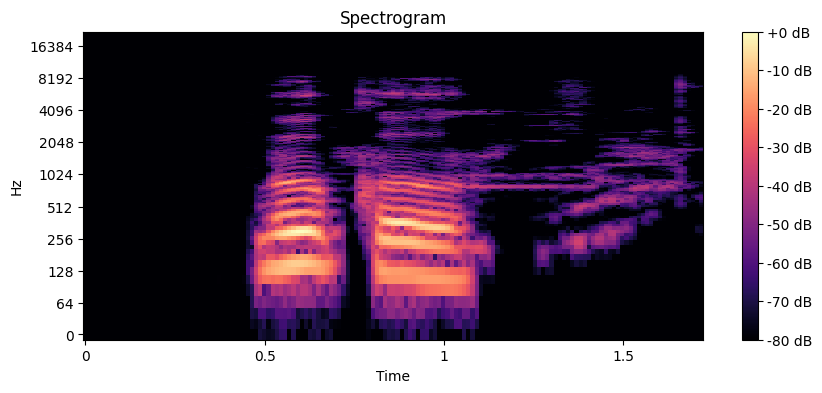

In [13]:
DATASET = "/content/calis_voice_dataset"
ADD_NOISE = "/content/add_noise"
SHIFT_AUDIO = "/content/shift_audio"
PITCH_SHIFT = "/content/pitch_shift_audio"
APPLY_TIME_STRETCH = "/content/apply_time_stretch"
AUGMENTATION_PATH = "/content/augmentation_path"


source_path = DATASET
visualizer = WavVisualizer(source_path)
visualizer.visualize_first_wav()

## Adding Noise to WAV Files

The `add_noise` function and `process_wav_files` function are defined as follows:

### `add_noise(data, noise_factor)`
- Adds random Gaussian noise to the input data with the specified noise factor.
- Returns the augmented data.

### `process_wav_files(dataset_folder, output_folder, noise_factor)`
- Creates the output folder if it doesn't exist.
- Iterates through the class folders in the dataset folder.
- For each class folder, iterates through the WAV files.
- For each WAV file, reads the data and sampling rate using `sf.read`.
- Augments the data by adding noise using the `add_noise` function.
- Writes the augmented data to a new WAV file in the output folder using `sf.write`.

In [14]:
def add_noise(data, noise_factor):
    noise = np.random.randn(*data.shape)
    augmented_data = data + noise_factor * noise
    return augmented_data

def process_wav_files(dataset_folder, output_folder, noise_factor):
    os.makedirs(output_folder, exist_ok=True)

    for class_folder in os.listdir(dataset_folder):
        class_folder_path = os.path.join(dataset_folder, class_folder)
        output_class_folder = os.path.join(output_folder, class_folder)
        os.makedirs(output_class_folder, exist_ok=True)

        for file in os.listdir(class_folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(class_folder_path, file)
                output_file_name = f"{os.path.splitext(file)[0]}_noisy_{noise_factor}{os.path.splitext(file)[1]}"
                output_file_path = os.path.join(output_class_folder, output_file_name)

                data, sampling_rate = sf.read(file_path)
                augmented_data = add_noise(data, noise_factor)
                sf.write(output_file_path, augmented_data, sampling_rate)

In [15]:
# dataset_folder = DATASET
# output_folder = "/content/add_noise_folder"
# noise_factor = 0.1

# process_wav_files(dataset_folder, output_folder, noise_factor)

In [16]:
# ADD_NOISE = "/content/add_noise_folder"
# visualizer = WavVisualizer(ADD_NOISE)
# visualizer.visualize_first_wav()

## Applying Time Shift to WAV Files

The `time_shift` function and `process_wav_files` function are defined as follows:

### `time_shift(audio, shift_max, shift_direction)`
- Applies time shift to the input audio data.
- Arguments:
  - `audio` (AudioSegment): The audio data.
  - `shift_max` (float): The maximum shift value as a fraction of the audio length.
  - `shift_direction` (str): The direction of the shift. Must be 'left', 'right', or 'both'.
- Returns:
  - `AudioSegment`: The time-shifted audio data.

### `process_wav_files(dataset_folder, output_folder, sampling_rate, shift_max, shift_direction)`
- Creates the output folder if it doesn't exist.
- Iterates through the class folders in the dataset folder.
- For each class folder, iterates through the WAV files.
- For each WAV file, reads the data using PyDub's `AudioSegment.from_file`.
- Applies time shift to the audio data using the `time_shift` function.
- Constructs the output file name and path.
- Exports the shifted audio to the output file using PyDub's `export` method.


In [17]:
def time_shift(audio, shift_max, shift_direction):
    """
    Apply time shift to the audio data.

    Args:
        audio (AudioSegment): The audio data.
        shift_max (float): The maximum shift value as a fraction of the audio length.
        shift_direction (str): The direction of the shift. Must be 'left', 'right', or 'both'.

    Returns:
        AudioSegment: The time-shifted audio data.
    """
    shift = int(len(audio) * shift_max)

    if shift_direction == 'right':
        shifted_audio = audio[-shift:]
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shifted_audio = audio[-shift:]
        else:
            shifted_audio = audio[:shift]
    else:
        raise ValueError("Invalid shift_direction. Must be 'left', 'right', or 'both'.")

    return shifted_audio

def process_wav_files(dataset_folder, output_folder, sampling_rate, shift_max, shift_direction):
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each class folder in the dataset
    for class_folder in os.listdir(dataset_folder):
        class_folder_path = os.path.join(dataset_folder, class_folder)

        # Create class folder in the output folder
        output_class_folder = os.path.join(output_folder, class_folder)
        os.makedirs(output_class_folder, exist_ok=True)

        # Iterate over each WAV file in the current class
        for file in os.listdir(class_folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(class_folder_path, file)

                # Read WAV file using PyDub
                audio = AudioSegment.from_file(file_path, format="wav")

                # Manipulate data with time_shift()
                shifted_audio = time_shift(audio, shift_max, shift_direction)

                # Get the base name and extension of the file
                base_name = os.path.splitext(file)[0]
                file_extension = os.path.splitext(file)[1]

                # Construct the output file name with "_shifted_<sampling_rate>_<shift_max>" appended before the file extension
                output_file_name = f"{base_name}_shifted_{sampling_rate}_{shift_max}{file_extension}"

                # Construct the output file path in the output class folder
                output_file_path = os.path.join(output_class_folder, output_file_name)

                # Export the shifted audio to the output file using PyDub
                shifted_audio.export(output_file_path, format="wav", parameters=["-ar", str(sampling_rate)])

In [18]:
# dataset_folder = DATASET
# output_folder = "/content/shift_audio_folder"
# sampling_rate = 44100
# shift_max = 0.5
# shift_direction = "both"

# process_wav_files(dataset_folder, output_folder, sampling_rate, shift_max, shift_direction)

In [19]:
# SHIFT_AUDIO = "/content/shift_audio_folder"
# visualizer = WavVisualizer(SHIFT_AUDIO)
# visualizer.visualize_first_wav()

## Pitch Shifting to WAV Files

The `pitch_shift_audio` function and `process_wav_files` function are defined as follows:

### `pitch_shift_audio(file_path, output_file_path, pitch_factor)`
- Pitch-shifts the audio file and saves the result to a new file.
- Arguments:
  - `file_path` (str): The path to the input audio file.
  - `output_file_path` (str): The path to save the output pitch-shifted audio file.
  - `pitch_factor` (float): The factor by which to shift the pitch of the audio.
    - A value greater than 1 raises the pitch, while a value less than 1 lowers the pitch.
- Returns:
  - None

### `process_wav_files(dataset_folder, output_folder, pitch_factor)`
- Creates the output folder if it doesn't exist.
- Iterates through the class folders in the dataset folder.
- For each class folder, iterates through the WAV files.
- For each WAV file, constructs the output file name and path.
- Calls the `pitch_shift_audio` function to pitch-shift the audio.
- Saves the pitch-shifted audio to the output file.

In [20]:
def pitch_shift_audio(file_path, output_file_path, pitch_factor):
    """
    Pitch-shift the audio file and save the result to a new file.

    Args:
        file_path (str): The path to the input audio file.
        output_file_path (str): The path to save the output pitch-shifted audio file.
        pitch_factor (float): The factor by which to shift the pitch of the audio.
            A value greater than 1 raises the pitch, while a value less than 1 lowers the pitch.

    Returns:
        None
    """
    audio = AudioSegment.from_wav(file_path)
    shifted_audio = audio._spawn(audio.raw_data, overrides={
        "frame_rate": int(audio.frame_rate * pitch_factor)
    })
    shifted_audio.export(output_file_path, format="wav")

def process_wav_files(dataset_folder, output_folder, pitch_factor):
    # Create the output folder
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each class folder in the dataset
    for class_folder in os.listdir(dataset_folder):
        class_folder_path = os.path.join(dataset_folder, class_folder)

        # Create the class folder in the output folder
        output_class_folder = os.path.join(output_folder, class_folder)
        os.makedirs(output_class_folder, exist_ok=True)

        # Iterate over each WAV file in the current class
        for file in os.listdir(class_folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(class_folder_path, file)

                # Create a more descriptive output file name
                output_file_name = f"{os.path.splitext(file)[0]}_pitch_shifted.wav"
                output_file_path = os.path.join(output_class_folder, output_file_name)

                # Manipulate the audio with pitch_shift_audio()
                pitch_shift_audio(file_path, output_file_path, pitch_factor)

In [21]:
dataset_folder = DATASET
output_folder = "/content/pitch_shift_audio_folder"
pitch_factor = 1.0

process_wav_files(dataset_folder, output_folder, pitch_factor)

<ipython-input-12-2163056dbf89>:58: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(waveform), ref=np.max)


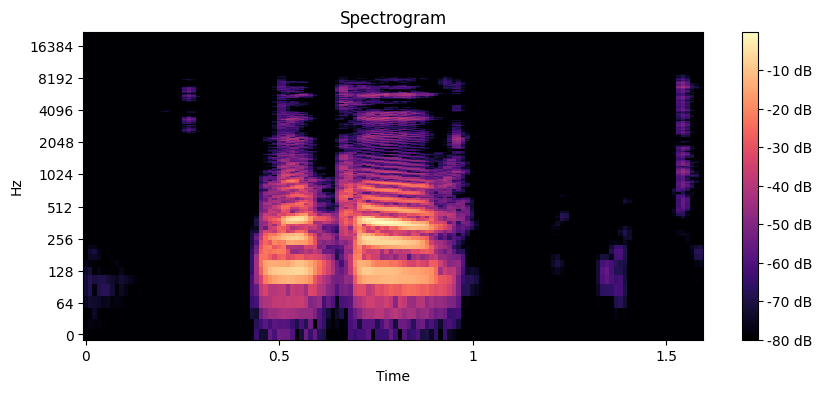

In [22]:
PITCH_SHIFT = "/content/pitch_shift_audio_folder"
visualizer = WavVisualizer(PITCH_SHIFT)
visualizer.visualize_first_wav()

## Applying Time Stretch to WAV Files

The `apply_time_stretch` function and `process_wav_files` function are defined as follows:

### `apply_time_stretch(audio, speed_factor)`
- Applies time stretching to the audio data.
- Arguments:
  - `audio` (AudioSegment): The audio data.
  - `speed_factor` (float): The factor by which to change the speed of the audio.
    - A value greater than 1 increases the speed, while a value less than 1 decreases the speed.
- Returns:
  - AudioSegment: The time-stretched audio data.

### `process_wav_files(dataset_folder, output_folder, speed_factor)`
- Creates the output folder if it doesn't exist.
- Iterates through the class folders in the dataset folder.
- For each class folder, iterates through the WAV files.
- For each WAV file, constructs the output file name and path.
- Calls the `apply_time_stretch` function to apply time stretching to the audio.
- Saves the time-stretched audio to the output file.


In [23]:
def apply_time_stretch(audio, speed_factor):
    """
    Apply time stretching to the audio data.

    Args:
        audio (AudioSegment): The audio data.
        speed_factor (float): The factor by which to change the speed of the audio.
            A value greater than 1 increases the speed, while a value less than 1 decreases the speed.

    Returns:
        AudioSegment: The time-stretched audio data.
    """
    return audio.speedup(playback_speed=speed_factor)

def process_wav_files(dataset_folder, output_folder, speed_factor):
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each class folder in the dataset
    for class_folder in os.listdir(dataset_folder):
        class_folder_path = os.path.join(dataset_folder, class_folder)

        # Create class folder in the output folder
        output_class_folder = os.path.join(output_folder, class_folder)
        os.makedirs(output_class_folder, exist_ok=True)

        # Iterate over each WAV file in the current class
        for file in os.listdir(class_folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(class_folder_path, file)

                # Read WAV file using PyDub
                audio = AudioSegment.from_file(file_path, format="wav")

                # Manipulate data with apply_time_stretch()
                manipulated_audio = apply_time_stretch(audio, speed_factor)

                # Get the base name and extension of the file
                base_name = os.path.splitext(file)[0]
                file_extension = os.path.splitext(file)[1]

                # Construct the output file name with the speed factor appended after the base name
                output_file_name = f"{base_name}_speed{speed_factor}{file_extension}"

                # Construct the output file path in the output class folder
                output_file_path = os.path.join(output_class_folder, output_file_name)

                # Write the manipulated audio to the output file using PyDub
                manipulated_audio.export(output_file_path, format="wav")

In [24]:
# dataset_folder = DATASET
# output_folder = "/content/apply_time_stretch_folder"
# speed_factor = 0.9

# process_wav_files(dataset_folder, output_folder, speed_factor)

In [25]:
# APPLY_TIME_STRETCH = "/content/apply_time_stretch_folder"
# visualizer = WavVisualizer(APPLY_TIME_STRETCH)
# visualizer.visualize_first_wav()

## Merging Folders

The `merge_folders` function is defined as follows:

### `merge_folders(source_folder, destination_folder)`
- Merges the contents of the source folder into the destination folder.
- Arguments:
  - `source_folder` (str): The path to the source folder.
  - `destination_folder` (str): The path to the destination folder.
- Returns:
  - None

This function iterates through the directory structure of the source folder and moves each file to the corresponding location in the destination folder, preserving the directory structure. After the merge is complete, the source folder is removed.

In [26]:
def merge_folders(source_folder, destination_folder):
    # Iterate through the directory structure of the source folder
    for root, dirs, files in os.walk(source_folder):
        # Get the destination folder path by using the same directory structure
        relative_path = os.path.relpath(root, source_folder)
        new_folder = os.path.join(destination_folder, relative_path)

        # Create the destination folder if it doesn't exist
        os.makedirs(new_folder, exist_ok=True)

        # Iterate through each file in the current folder
        for file in files:
            # Get the source and destination file paths
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(new_folder, file)

            # Move the file from the source folder to the destination folder
            shutil.move(source_file_path, destination_file_path)

    # Remove the source folder after the merge is complete
    shutil.rmtree(source_folder)

# Merge All Folder Augmentation

In [27]:
# # Path to the source dataset folder
# source_folder = ADD_NOISE

# # Path to the destination folder to merge with the same folder structure
# destination_folder = AUGMENTATION_PATH

# # Create the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# # Merge folders with the same structure
# merge_folders(source_folder, destination_folder)

In [28]:
# # Path to the source dataset folder
# source_folder = SHIFT_AUDIO

# # Path to the destination folder to merge with the same folder structure
# destination_folder = AUGMENTATION_PATH

# # Create the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# # Merge folders with the same structure
# merge_folders(source_folder, destination_folder)

In [29]:
# Path to the source dataset folder
source_folder = PITCH_SHIFT

# Path to the destination folder to merge with the same folder structure
destination_folder = AUGMENTATION_PATH

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Merge folders with the same structure
merge_folders(source_folder, destination_folder)

In [30]:
# # Path to the source dataset folder
# source_folder = APPLY_TIME_STRETCH

# # Path to the destination folder to merge with the same folder structure
# destination_folder = AUGMENTATION_PATH

# # Create the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# # Merge folders with the same structure
# merge_folders(source_folder, destination_folder)

## DataFolder Class

The `DataFolder` class is defined as follows:

### `__init__(self, folder_path, csv_file_path)`
- Initializes a `DataFolder` object.
- Arguments:
  - `folder_path` (str): The path to the folder containing audio files.
  - `csv_file_path` (str): The path to the CSV file that will store the audio file information.
- Returns:
  - None

### `convert_folder_to_csv(self)`
- Converts the folder of audio files into a CSV file.
- Each row in the CSV file corresponds to an audio file, with the 'filename' column storing the file names and the 'class' column storing the corresponding class names.
- Returns:
  - None

### `assign_folds(self, n_splits=10, shuffle=True, random_state=None, validation_num=1, test_num=1, fix_fold=None)`
- Assigns fold values to each sample in the CSV file.
- The 'fold' column is added to the CSV file, indicating which fold the sample belongs to based on K-fold cross-validation.
- Arguments:
  - `n_splits` (int): The number of folds for cross-validation (default: 10).
  - `shuffle` (bool): Whether to shuffle the data before splitting into folds (default: True).
  - `random_state` (int or None): Random seed for shuffling the data (default: None).
  - `validation_num` (int): The number of samples to include in the validation set (default: 1).
  - `test_num` (int): The number of samples to include in the test set (default: 1).
  - `fix_fold` (int or None): Fix the fold value for all samples (default: None).
- Returns:
  - None

This class provides methods for converting a folder of audio files into a CSV file and assigning fold values to the samples in the CSV file for cross-validation. The fold values are stored in the 'fold' column of the CSV file.

In [31]:
# Define a class for handling data operations
class DataFolder:
    def __init__(self, folder_path, csv_file_path):
        self.folder_path = folder_path
        self.csv_file_path = csv_file_path

    def convert_folder_to_csv(self):
        """
        Convert a folder of audio files into a CSV file.
        Each row in the CSV file corresponds to an audio file,
        with the 'filename' column storing the file names
        and the 'class' column storing the corresponding class names.
        """
        filenames = []
        classes = []
        for root, dirs, files in os.walk(self.folder_path):
            for file in files:
                if file.endswith('.wav'):
                    filenames.append(file)
                    class_name = os.path.basename(root)
                    classes.append(class_name)

        data = {'filename': filenames, 'class': classes}
        df = pd.DataFrame(data)
        df.to_csv(self.csv_file_path, index=False)

    def assign_folds(self, n_splits=10, shuffle=True, random_state=None, validation_num=1, test_num=1, fix_fold=None):
        """
        Assign fold values to each sample in the CSV file.
        The 'fold' column is added to the CSV file, indicating
        which fold the sample belongs to based on the K-fold cross-validation.
        """
        df = pd.read_csv(self.csv_file_path)
        kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        df['fold'] = -1

        for fold, (_, val_indexes) in enumerate(kfold.split(df)):
            if fix_fold is not None:
              df.loc[val_indexes, 'fold'] = fix_fold
              continue
            df.loc[val_indexes, 'fold'] = fold

        # prev_class_name = None
        # test_counter = 0
        # val_counter = 0

        # for index, row in df.iterrows():
        #     class_name = row["class"]

        #     if prev_class_name != class_name:
        #         val_counter = 0
        #         test_counter = 0
        #         prev_class_name = class_name

        #     if test_counter < test_num:
        #         df.at[index, "fold"] = 1
        #         test_counter += 1
        #     elif val_counter < validation_num:
        #         df.at[index, "fold"] = 2
        #         val_counter += 1
        #     else:
        #         df.at[index, "fold"] = 0

        df.to_csv(self.csv_file_path, index=False)

In [32]:
csv_file_path = 'DATASET.csv'

data_folder = DataFolder(DATASET, csv_file_path)
data_folder.convert_folder_to_csv()
data_folder.assign_folds(n_splits=5, shuffle=True, random_state=42)

augmentation_csv_filepath = 'DATASET_AUGMENTASI.csv'
augmentation_folder = DataFolder(AUGMENTATION_PATH, augmentation_csv_filepath)
augmentation_folder.convert_folder_to_csv()
augmentation_folder.assign_folds(fix_fold=3)

The code snippet `df = pd.read_csv(csv_file_path)` reads the CSV file located at `csv_file_path` and stores the data in a pandas DataFrame called `df`.

### `pd.read_csv(csv_file_path)`
- Reads a CSV (Comma-Separated Values) file and returns a DataFrame.
- Arguments:
  - `csv_file_path` (str): The path to the CSV file.
- Returns:
  - DataFrame: The data read from the CSV file.

The `pd.read_csv()` function is a pandas function used to read CSV files and create a DataFrame object. It takes the file path of the CSV file as an argument and returns a DataFrame containing the data from the CSV file.

In the code snippet, the DataFrame object `df` is created by reading the CSV file located at `csv_file_path` using the `pd.read_csv()` function. The `df` DataFrame can then be used to perform various data manipulation and analysis tasks using the pandas library.

Note that the code assumes that the pandas library is imported and assigned the alias `pd`. The `df` variable can be used to access and manipulate the data stored in the DataFrame.

In [33]:
df = pd.read_csv(csv_file_path)
df

,filename,class,fold
0,buku(28).wav,buku,1
1,buku(42).wav,buku,4
2,buku(5).wav,buku,0
3,buku(8).wav,buku,0
4,buku(26).wav,buku,4
...,...,...,...
1059,adab(45).wav,adab,4
1060,adab(30).wav,adab,0
1061,adab(14).wav,adab,2
1062,adab(42).wav,adab,2


The code snippet `df.info()` provides information about the DataFrame `df`, including the column names, data types, and memory usage.

### `df.info()`
- Prints a concise summary of the DataFrame.
- Returns:
  - None

The `info()` method is a pandas DataFrame method that displays a summary of the DataFrame's structure and content. When called on a DataFrame object, it prints the following information:
- The total number of rows and columns in the DataFrame.
- The column names and their corresponding data types.
- The number of non-null values in each column.
- The memory usage of the DataFrame.

The `df.info()` output is useful for understanding the overall structure of the DataFrame, identifying missing or null values, and assessing the memory usage of the DataFrame.

By calling `df.info()`, you can quickly get an overview of the DataFrame's data types and check for any missing or null values. This information can help you make informed decisions about data cleaning, preprocessing, and analysis tasks.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1064 non-null   object
 1   class     1064 non-null   object
 2   fold      1064 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.1+ KB


The code snippet `df.shape` returns the dimensions of the DataFrame `df`, representing the number of rows and columns.

### `df.shape`
- Returns a tuple representing the dimensions of the DataFrame.
- The first element of the tuple represents the number of rows.
- The second element of the tuple represents the number of columns.

By calling `df.shape`, you can quickly obtain the size of the DataFrame in terms of its row and column count. This information is useful for understanding the overall structure and size of the DataFrame.

For example, if `df.shape` returns `(1000, 5)`, it means that the DataFrame contains 1000 rows and 5 columns.

Knowing the shape of the DataFrame is essential for performing various data manipulation and analysis tasks. It helps you understand the scope of your data, determine appropriate indexing or slicing operations, and ensure compatibility with other operations or datasets.

You can use the shape information to verify if the DataFrame has the expected dimensions, identify potential data issues (e.g., missing rows or unexpected column count), or perform calculations or comparisons based on the DataFrame's size.

In [35]:
df.shape

(1064, 3)

In [36]:
df_aug = pd.read_csv(augmentation_csv_filepath)
df_aug

,filename,class,fold
0,buku(6)_pitch_shifted.wav,buku,3
1,buku(50)_pitch_shifted.wav,buku,3
2,buku(48)_pitch_shifted.wav,buku,3
3,buku(22)_pitch_shifted.wav,buku,3
4,buku(60)_pitch_shifted.wav,buku,3
...,...,...,...
1059,adab(25)_pitch_shifted.wav,adab,3
1060,adab(44)_pitch_shifted.wav,adab,3
1061,adab(46)_pitch_shifted.wav,adab,3
1062,adab(38)_pitch_shifted.wav,adab,3


In [37]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1064 non-null   object
 1   class     1064 non-null   object
 2   fold      1064 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.1+ KB


In [38]:
df_aug.shape

(1064, 3)

### Extracting Unique Class Names
- `class_names = df.iloc[:, 1].unique()` extracts the unique class names from the second column of the DataFrame `df`. The `iloc[:, 1]` indexing selects all rows of the second column, and the `unique()` function returns an array of unique class names.

### Creating a Mapping Dictionary
- `map_class_to_id = {class_name: class_id for class_id, class_name in enumerate(class_names)}` creates a mapping dictionary `map_class_to_id` that maps each unique class name to a unique class ID. The `enumerate()` function assigns a unique `class_id` to each `class_name`.

### Assigning Class IDs to DataFrames
- `class_id = df['class'].apply(lambda name: map_class_to_id[name])` assigns a class ID to each row in the DataFrame `df` by mapping the class name to its corresponding class ID using the `map_class_to_id` dictionary. The `apply()` function applies the lambda function to each value in the 'class' column.
- `pd_data = df.assign(target=class_id)` assigns the class IDs as a new column named 'target' in the DataFrame `pd_data`. The `assign()` function creates a new DataFrame with the additional column.

### Modifying File Paths
- The `get_base_full_path(row)` function takes a row from the DataFrame `pd_data` and returns the full path of the original audio file by combining the dataset folder path, class name, and filename.
- The `get_augmentation_full_path(row)` function takes a row from the DataFrame `pd_data_aug` and returns the full path of the augmented audio file by combining the augmentation folder path, class name, and filename.
- `pd_data['filename'] = pd_data.apply(get_base_full_path, axis=1)` applies the `get_base_full_path()` function to each row in the DataFrame `pd_data` to modify the 'filename' column with the full path of the original audio file.
- `pd_data_aug['filename'] = pd_data_aug.apply(get_augmentation_full_path, axis=1)` applies the `get_augmentation_full_path()` function to each row in the DataFrame `pd_data_aug` to modify the 'filename' column with the full path of the augmented audio file.

### Merging DataFrames
- `pd_data = pd.concat([pd_data_aug, pd_data])` merges the DataFrames `pd_data_aug` and `pd_data` using the `concat()` function from the pandas library. The result is assigned back to `pd_data`, which now contains both the original and augmented data.

The code prepares the data by assigning class IDs, modifying file paths, and then merging the augmented data into the original data. These steps are crucial for maintaining data integrity and consistency throughout the merging process.

In [39]:
# Get the unique class names from the second column of the CSV
class_names = df.iloc[:, 1].unique()

# Create the mapping dictionary
map_class_to_id = {class_name: class_id for class_id, class_name in enumerate(class_names)}

class_id = df['class'].apply(lambda name: map_class_to_id[name])
pd_data = df.assign(target=class_id)
pd_data_aug = df_aug.assign(target=class_id)

def get_base_full_path(row):
    class_name = row['class']
    filename = row['filename']
    full_path = os.path.join(DATASET, class_name, filename)
    return full_path

def get_augmentation_full_path(row):
    class_name = row['class']
    filename = row['filename']
    full_path = os.path.join(AUGMENTATION_PATH, class_name, filename)
    return full_path

pd_data['filename'] = pd_data.apply(get_base_full_path, axis=1)
pd_data_aug['filename'] = pd_data_aug.apply(get_augmentation_full_path, axis=1)

pd_data = pd.concat([pd_data_aug, pd_data])

In [40]:
pd_data

,filename,class,fold,target
0,/content/augmentation_path/buku/buku(6)_pitch_...,buku,3,0
1,/content/augmentation_path/buku/buku(50)_pitch...,buku,3,0
2,/content/augmentation_path/buku/buku(48)_pitch...,buku,3,0
3,/content/augmentation_path/buku/buku(22)_pitch...,buku,3,0
4,/content/augmentation_path/buku/buku(60)_pitch...,buku,3,0
...,...,...,...,...
1059,/content/calis_voice_dataset/adab/adab(45).wav,adab,4,17
1060,/content/calis_voice_dataset/adab/adab(30).wav,adab,0,17
1061,/content/calis_voice_dataset/adab/adab(14).wav,adab,2,17
1062,/content/calis_voice_dataset/adab/adab(42).wav,adab,2,17


### Load Audio Files and Retrieve Embeddings

In this step, the `load_wav_16k_mono` function is used to load the WAV audio files and prepare the data for the model. The loaded audio is processed to extract embeddings, resulting in an array with a shape of `(N, 1024)`. The value `N` represents the number of frames that YAMNet has detected, with each frame corresponding to approximately 0.48 seconds of audio. The extracted embeddings capture meaningful information about the audio content and will be used as input for further analysis or model training.

### Reshaping Data for Frame-level Inputs

To prepare the data for frame-level modeling, each frame needs to be treated as an individual input. This requires transforming the dataset so that each frame is represented by a separate row.

To achieve this, a new column is created where each row corresponds to one frame. The labels and the `fold` column are expanded to properly reflect these new rows. The expanded `fold` column retains the original values to ensure that parts of the same audio are not split across different folds during the validation and test steps. This separation is crucial to maintain the effectiveness of the validation and test procedures.

By reshaping the data in this manner, the model can process each frame individually, enabling more granular analysis and leveraging the temporal information present in the audio data.

In [41]:
# Extract the filenames, targets, and folds from the provided pandas DataFrame
filenames = pd_data['filename']
targets = pd_data['target']
folds = pd_data['fold']

# Create a TensorFlow Dataset from the extracted data
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

# Print the element specification of the main dataset
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [42]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [43]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# Caching and Preparing Datasets

To optimize performance and ensure faster access to the data, the main dataset (`main_ds`) is cached using `cached_ds`. This allows subsequent operations to retrieve the data from the cache rather than reading it from the original source.

The cached dataset is then filtered to create three separate datasets: `train_ds`, `val_ds`, and `test_ds`. Each dataset is based on the values of the `fold` column. The training dataset (`train_ds`) contains samples where the fold value is greater than 1, the validation dataset (`val_ds`) contains samples where the fold value is 1, and the test dataset (`test_ds`) contains samples where the fold value is 0.

Since the fold column is no longer needed for further processing, it is removed from the datasets using a mapping function.

For the training dataset, additional operations are performed to optimize training efficiency. The training dataset is cached again to improve access speed, shuffled to introduce randomness during training, batched into batches of size 32 for efficient processing, and prefetched to overlap the preprocessing and model execution.

Similarly, the validation and test datasets are also cached for faster access, batched for processing, and prefetched for performance optimization.

By applying these caching and preprocessing steps, the datasets are prepared in an efficient and optimized manner for training, validation, and testing of the model.

In [44]:
# Cache the main dataset for faster access
cached_ds = main_ds.cache()

# Filter the cached dataset to create training, validation, and test datasets based on fold values
train_ds = cached_ds.filter(lambda embedding, label, fold: fold > 1)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 1)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 0)

# Remove the folds column from the datasets since it's no longer needed
remove_fold_column = lambda embedding, label, fold: (embedding, label)
train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

# Cache, shuffle, batch, and prefetch the training dataset
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Cache, batch, and prefetch the validation dataset
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Cache, batch, and prefetch the test dataset
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Model Definition and Compilation

The model is defined using the `Sequential` API from TensorFlow Keras. It consists of several layers:

1. The input layer (`Input`) with a shape of (1024,), representing the size of each embedding.
2. A fully connected layer (`Dense`) with 5555 units and a ReLU activation function.
3. Another fully connected layer (`Dense`) with 1024 units and a ReLU activation function.
4. The output layer (`Dense`) with 18 units and a softmax activation function, which outputs the probability distribution over the 18 classes.

The model summary provides an overview of the model architecture, including the layer types, shapes, and the number of parameters.

After defining the model, it is compiled using the Adam optimizer, which is a popular optimization algorithm. The loss function used is the sparse categorical cross-entropy, suitable for multi-class classification tasks. The model's performance will be evaluated based on the accuracy metric.

# Model Training

The model is trained using the `fit` function. The training data is provided through the `train_ds` dataset, and the validation data is provided through the `val_ds` dataset. The model is trained for 100 epochs, meaning it will iterate over the training data 100 times.

During training, the model's performance and progress are monitored, and the training history is stored in the `history` variable. This history object can be used to analyze the training metrics and visualize the training progress.

Callbacks can also be added during training to perform specific actions at different stages, such as saving the best model weights or early stopping based on certain conditions. However, the callbacks are not specified in the provided code.

By executing this code, the model will be compiled, trained, and the training history will be saved in the `history` variable.

In [45]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(5555, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(18, activation='softmax')
])
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model for 100 epochs and save the training history
history = model.fit(train_ds, epochs=100, validation_data=val_ds)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5555)              5693875   
                                                                 
 dense_1 (Dense)             (None, 1024)              5689344   
                                                                 
 dense_2 (Dense)             (None, 18)                18450     
                                                                 
Total params: 11,401,669
Trainable params: 11,401,669
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


162/162 [==============================] - 79s 393ms/step - loss: 2.6735 - accuracy: 0.1768 - val_loss: 2.8657 - val_accuracy: 0.1797
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 2.2944 - accuracy: 0.2785 - val_loss: 2.4825 - val_accuracy: 0.2109
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 1.9747 - accuracy: 0.3634 - val_loss: 2.0671 - val_accuracy: 0.3609
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 1.6109 - accuracy: 0.4797 - val_loss: 1.9162 - val_accuracy: 0.4031
Epoch 5/100
162/162 [==============================] - 1s 6ms/step - loss: 1.3415 - accuracy: 0.5687 - val_loss: 1.6754 - val_accuracy: 0.4547
Epoch 6/100
162/162 [==============================] - 1s 5ms/step - loss: 1.0914 - accuracy: 0.6457 - val_loss: 1.4460 - val_accuracy: 0.5297
Epoch 7/100
162/162 [==============================] - 1s 5ms/step - loss: 0.8722 - accuracy: 0.7180 - val_loss: 1.2908 - val_accuracy: 0.5641
Epoch 8/

## Model Accuracy Plot

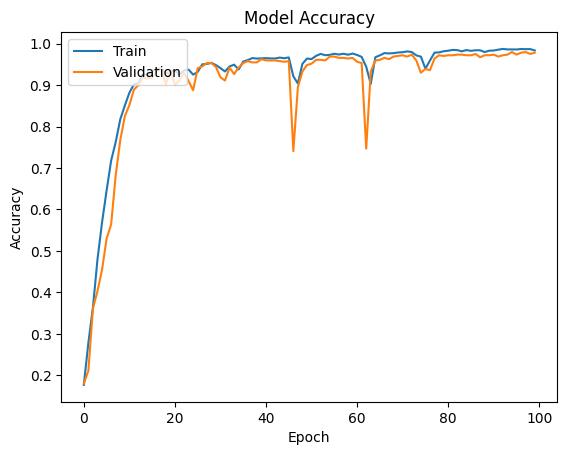

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation Results

In [47]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

21/21 [==============================] - 0s 6ms/step - loss: 0.0524 - accuracy: 0.9863
Loss:  0.05242098867893219
Accuracy:  0.9862595200538635


The `ReduceMeanLayer` class is a custom layer in TensorFlow that calculates the mean along a specified axis. It inherits from the `tf.keras.layers.Layer` class, which provides the basic functionality for creating custom layers.

The constructor (`__init__` method) of `ReduceMeanLayer` initializes the layer and accepts an optional argument `axis` which determines the axis along which the mean operation will be performed.

The `call` method is where the layer's logic is defined. It takes the input tensor and applies the `tf.math.reduce_mean` function to calculate the mean along the specified axis. The resulting tensor is then returned as the output of the layer.

By using this custom layer in a TensorFlow model, you can easily incorporate the mean reduction operation into your network architecture.

In [48]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

## Converting and Saving the Model

1. Specify the path where the SavedModel will be saved.
2. Define the input layer for the audio segment.
3. Create a KerasLayer for the YAMNet model, using the specified handle.
4. Apply the YAMNet layer to the input segment to obtain the embeddings output.
5. Pass the embeddings output through the 'model' to obtain the serving outputs.
6. Apply the ReduceMeanLayer to the serving outputs along axis 0.
7. Create a serving model using the input segment as the input and the serving outputs as the output.
8. Save the serving model as a SavedModel without including the optimizer state.
9. Convert the SavedModel to a TFLite model.
10. Save the TFLite model to a file.

In [49]:
# Specify the path where the SavedModel will be saved
saved_model_path = './calis_voice_yamnet'

# Define the input layer for the audio segment
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')

# Create a KerasLayer for the YAMNet model, using the specified handle
# The layer is set as non-trainable and named 'yamnet'
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet')

# Apply the YAMNet layer to the input segment to obtain the embeddings output
# The unused intermediate outputs are denoted with underscores (_)
_, embeddings_output, _ = embedding_extraction_layer(input_segment)

# Pass the embeddings output through the 'model' to obtain the serving outputs
serving_outputs = model(embeddings_output)

# Apply the ReduceMeanLayer to the serving outputs along axis 0
# The layer is named 'classifier'
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

# Create a serving model using the input segment as the input and the serving outputs as the output
serving_model = tf.keras.Model(input_segment, serving_outputs)

# Save the serving model as a SavedModel without including the optimizer state
serving_model.save(saved_model_path, include_optimizer=False)

In [50]:
# Save the model as a SavedModel
serving_model.save(saved_model_path, include_optimizer=False)

# Convert the SavedModel to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = './calis_voice_yamnet.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)